# Lesson 03 Exercises

## E03 - Q1 Hyper Parameter for lower loss
Tune the hyperparameters to beat 2.2.
Work out the optimal hyper parameters to tune the network to achieve lower loss on the test set
AndreL :2.17

Other peoples tests: 
1.89, 300K iterations 23K paras, blocksize=4, embedings 12 hidden layer 300
training delay: learning rate exponent from -1 to -3 linear space over 300k steps

Setup a set of hyperparameters and pass each set into the initalised model and run training. Calculate training and dev losses. 


In [3]:
import torch, torch.nn.functional as F, matplotlib.pyplot as plt, random, time

In [4]:
words = open("../names.txt").read().splitlines()

In [5]:
chars = sorted(list(set(''.join(words))) + ['.'])
itos = {idx: ch for idx, ch in enumerate(chars)}
stoi = {v:k for k, v in itos.items()}

In [6]:
def build_dataset(words, block_size=3):
    # build the full dataset
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    # print(X.shape, Y.shape)
    return X, Y

def calc_loss(embed_dims, block_size):
    losses = []
    for x, y in ([(Xtr, Ytr), (Xdev, Ydev)]):
        emb = C[x]
        h = torch.tanh(emb.view(-1,embed_dims * block_size) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, y)
        losses.append(loss.item())
    return losses[0],losses[1]

In [7]:
# split dataset

def split_dataset(X,Y):
    random.seed(42); 
    random.shuffle(words) # randomly shuffle words
    
    n1 = int(0.8 * X.shape[0])
    n2 = int(0.9 * X.shape[0])
    Xtr, Xdev, Xts = X.tensor_split((n1, n2), dim=0)
    Ytr, Ydev, Yts = Y.tensor_split((n1, n2), dim=0)
    
    return Xtr, Xdev, Xts, Ytr, Ydev, Yts

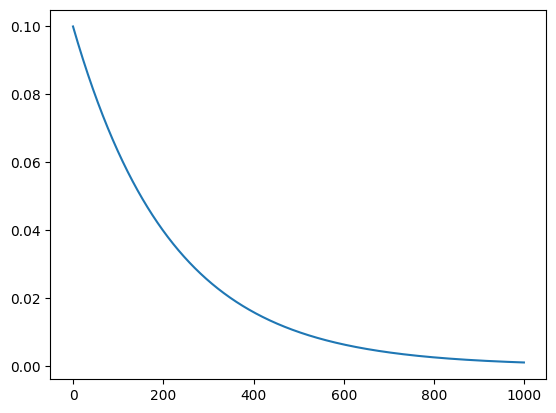

In [15]:
lre = torch.linspace(-1, -3, 1000)
lrs = 10**lre
plt.plot(lrs);

In [2]:
def get_lr_step(i, max_i):
    return 0.1 if i < 100_000 else 0.01

def get_lr_decay(i, max_i):
    x = torch.linspace(-1,-3, max_i)[i]
    return (10**x).item()

In [14]:
hyper_params = [
    # {"test_id": 1, "block_size":3, "embed_dims":10, "hidden_layer":100, "mini_batches":32, "tr_i": 100_000, "lr_algo": get_lr_step},
    # {"test_id": 2, "block_size":3, "embed_dims":10, "hidden_layer":100, "mini_batches":32, "tr_i": 100_000, "lr_algo": get_lr_step},
    # {"test_id": 3, "block_size":3, "embed_dims":10, "hidden_layer":100, "mini_batches":32, "tr_i": 100_000, "lr_algo": get_lr_step},
    # {"test_id": 4, "block_size":3, "embed_dims":10, "hidden_layer":100, "mini_batches":32, "tr_i": 100_000, "lr_algo": get_lr_step},
    # {"test_id": 5, "block_size":4, "embed_dims":10, "hidden_layer":100, "mini_batches":32, "tr_i": 100_000, "lr_algo": get_lr_step},
    {"test_id": 51, "block_size":3, "embed_dims":10, "hidden_layer":200, "mini_batches":32, "tr_i": 200_000, "lr_algo": get_lr_step},
    # {"test_id": 6, "block_size":4, "embed_dims":12, "hidden_layer":300, "mini_batches":32, "tr_i": 100_000, "lr_algo": get_lr_step},
    # {"test_id": 7, "block_size":4, "embed_dims":12, "hidden_layer":300, "mini_batches":32, "tr_i": 300_000, "lr_algo": get_lr_step},
    # {"test_id": 8, "block_size":4, "embed_dims":12, "hidden_layer":300, "mini_batches":32, "tr_i": 500_000, "lr_algo": get_lr_step},
    # {"test_id": 9, "block_size":4, "embed_dims":12, "hidden_layer":300, "mini_batches":32, "tr_i": 600_000, "lr_algo": get_lr_step},
    # {"test_id": 10, "block_size":4, "embed_dims":12, "hidden_layer":500, "mini_batches":32, "tr_i": 600_000, "lr_algo": get_lr_step},
    # {"test_id": 11, "block_size":4, "embed_dims":12, "hidden_layer":300, "mini_batches":64, "tr_i": 300_000, "lr_algo": get_lr_step},
    # {"test_id": 12, "block_size":4, "embed_dims":12, "hidden_layer":300, "mini_batches":64, "tr_i": 300_000, "lr_algo": get_lr_decay}
    ]

In [15]:
for hp in hyper_params:

    # get hyper parameters
    test_id, block_size, embed_dims, hidden_layer, mini_batches, tr_i, lr_algo = hp.values()
    # setup dataset
    Xtr, Xdev, Xts, Ytr, Ydev, Yts = split_dataset(*build_dataset(words, block_size))
    
    # initialise nn
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((27,embed_dims), generator = g)
    W1 = torch.randn((embed_dims * block_size, hidden_layer), generator=g)
    b1 = torch.randn(hidden_layer, generator=g)
    W2 = torch.randn((hidden_layer,27), generator=g)
    b2 = torch.randn(27, generator=g)
    parameters = [C, W1, b1, W2, b2]

    for p in parameters:
        p.requires_grad = True
    
    num_params = sum(p.nelement() for p in parameters)
    start_time = time.time()
    
    for i in range(tr_i + 1):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (mini_batches,))
        
        # forward pass
        emb = C[Xtr[ix]] 
        h = torch.tanh(emb.view(-1, embed_dims * block_size) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix]) 
            
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # lr = 0.1 if i < 100_000 else 0.01
        lr = lr_algo(i, tr_i + 1)
        
        # report loss
        if i % 10000 == 0:
            print(f"{i:8}|{lr:4}|{loss.item():.4f}")
        
        # update
        for p in parameters:
            p.data += -lr * p.grad  
    
        # stepi.append(i)
        # lossi.append(loss.log10().item())
    duration = time.time() - start_time
    tr_loss, dev_loss = calc_loss(embed_dims, block_size)

    print(f"{test_id}: {block_size=} {embed_dims=:3} {hidden_layer=:3} {mini_batches=} {tr_i=} {num_params=:6} {duration=:.4f} {tr_loss=:.6f} {dev_loss=:.6f}")



       0| 0.1|25.8874
   10000| 0.1|2.2963
   20000| 0.1|2.5512
   30000| 0.1|2.7335
   40000| 0.1|2.8117
   50000| 0.1|2.1570
   60000| 0.1|2.4027
   70000| 0.1|2.4081
   80000| 0.1|2.5987
   90000| 0.1|2.1911
  100000|0.01|1.9555
  110000|0.01|2.2841
  120000|0.01|2.1660
  130000|0.01|2.0526
  140000|0.01|2.0045
  150000|0.01|2.4833
  160000|0.01|1.8466
  170000|0.01|2.0274
  180000|0.01|1.9987
  190000|0.01|2.1108
  200000|0.01|2.0268
51: block_size=3 embed_dims= 10 hidden_layer=200 mini_batches=32 tr_i=200000 num_params= 11897 duration=90.2837 tr_loss=2.114949 dev_loss=2.157162


In [51]:
# Results
#51: block_size=3 embed_dims= 10 hidden_layer=200 mini_batches=32 tr_i=200000 num_params= 11897 duration=90.2837 tr_loss=2.114949 dev_loss=2.157162
# 7: block_size=4 embed_dims= 12 hidden_layer=300 mini_batches=32 tr_i=300000 num_params= 23151 duration=115.7265 tr_loss=2.138358 dev_loss=2.192055
# 8: block_size=4 embed_dims= 12 hidden_layer=300 mini_batches=32 tr_i=500000 num_params= 23151 duration=192.8683 tr_loss=2.111377 dev_loss=2.162301 
# 9: block_size=4 embed_dims= 12 hidden_layer=300 mini_batches=32 tr_i=600000 num_params= 23151 duration=288.7984 tr_loss=2.110690 dev_loss=2.192899
#10: block_size=4 embed_dims= 12 hidden_layer=500 mini_batches=32 tr_i=600000 num_params= 38351 duration=276.0203 tr_loss=2.132846 dev_loss=2.198221
#11: block_size=4 embed_dims= 12 hidden_layer=300 mini_batches=64 tr_i=300000 num_params= 23151 duration=143.7739 tr_loss=2.075785 dev_loss=2.171427  << best
#12: block_size=4 embed_dims= 12 hidden_layer=300 mini_batches=64 tr_i=300000 num_params= 23151 duration=173.0480 tr_loss=2.128890 dev_loss=2.182796


In [39]:
emb = C[Xts]
h = torch.tanh(emb.view(-1 ,12 * 4) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yts)
loss.item() # 2.280

2.1938986778259277

### model sampling

In [40]:
g = torch.Generator().manual_seed(2147483647+11)
block_size = 4

for _ in range(20):
    # reset
    context = [0] * block_size
    word = []

    # generate word
    while True: 
        emb = C[context]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1) # emb.view(1, -1) - just one row input
        logits = h @ W2 + b2
        counts = logits.exp() # 1 character output : 1,27
        p = counts / counts.sum(1, keepdim=True) # same as just counts.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        # context = torch.cat((context[1:], torch.tensor([idx])))
        context = context[1:] + [ix]
        if itos[ix] == '.':
            break
        word.append(itos[ix])
    print (''.join(word))


reenandr
kazarghrawyenzy
lina
krizzlyn
shrin
eevisso
meei
hamellanir
anis
malzee
kenlie
auesondeles
lola
law
suthusa
rydes
kashria
laree
laya
merah


## E03 - Q2: initial network initialisation impact

Attempt to train a model when the initalised weights are uniform and compare when they are randomly distributed in a binominal with mean 0.

In [49]:
hyper_params = [{"test_id": 11, "block_size":4, "embed_dims":12, "hidden_layer":300, "mini_batches":64, "tr_i": 50_000, "lr_algo": get_lr_step}]

In [80]:
for hp in hyper_params:

    # get hyper parameters
    test_id, block_size, embed_dims, hidden_layer, mini_batches, tr_i, lr_algo = hp.values()
    # setup dataset
    Xtr, Xdev, Xts, Ytr, Ydev, Yts = split_dataset(*build_dataset(words, block_size))
    
    # initialise nn
    # g = torch.Generator().manual_seed(2147483647)
    # C = torch.randn((27,embed_dims), generator = g)
    # W1 = torch.randn((embed_dims * block_size, hidden_layer), generator=g)
    # b1 = torch.randn(hidden_layer, generator=g)
    # W2 = torch.randn((hidden_layer,27), generator=g)
    # b2 = torch.randn(27, generator=g)

    # uniform distribution
    # C = torch.full((27,embed_dims), 1/embed_dims)
    # W1 = torch.full((embed_dims * block_size, hidden_layer), 1/hidden_layer)
    # b1 = torch.full((hidden_layer,), 1/hidden_layer)
    # W2 = torch.full((hidden_layer,27), 1/27)
    # b2 = torch.full((27,), 1/27)

    # all zeros
    C = torch.zeros((27,embed_dims), )
    W1 = torch.zeros((embed_dims * block_size, hidden_layer))
    b1 = torch.zeros((hidden_layer,))
    W2 = torch.zeros((hidden_layer,27))
    b2 = torch.zeros((27))

    
    parameters = [C, W1, b1, W2, b2]
    
    for p in parameters:
        p.requires_grad = True
    
    num_params = sum(p.nelement() for p in parameters)
    start_time = time.time()
    
    for i in range(tr_i + 1):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (mini_batches,))
        
        # forward pass
        emb = C[Xtr[ix]] 
        h = torch.tanh(emb.view(-1, embed_dims * block_size) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix]) 
            
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # lr = 0.1 if i < 100_000 else 0.01
        lr = lr_algo(i, tr_i + 1)
        
        # report loss
        report_i = 10_000
        if i % report_i == report_i-1:
            print(f"{i:8}|{lr:4}|{loss.item():.4f}")
        
        # update
        for p in parameters:
            p.data += -lr * p.grad  
    
        # stepi.append(i)
        # lossi.append(loss.log10().item())
    duration = time.time() - start_time
    tr_loss, dev_loss = calc_loss(embed_dims, block_size)

    print(f"{test_id}: {block_size=} {embed_dims=:3} {hidden_layer=:3} {mini_batches=} {tr_i=} {num_params=:6} {duration=:.4f} {tr_loss=:.6f} {dev_loss=:.6f}")


    9999| 0.1|2.6831
   19999| 0.1|2.8205
   29999| 0.1|2.6981
   39999| 0.1|2.7823
   49999| 0.1|2.7243
11: block_size=4 embed_dims= 12 hidden_layer=300 mini_batches=64 tr_i=50000 num_params= 23151 duration=22.5588 tr_loss=2.823123 dev_loss=2.824324


In [ ]:
# Results
# 11: block_size=4 embed_dims= 12 hidden_layer=300 mini_batches=64 tr_i=50000 num_params= 23151 duration=20.9286 tr_loss=2.286725 dev_loss=2.313228

# with uniform distribution: 
# 11: block_size=4 embed_dims= 12 hidden_layer=300 mini_batches=64 tr_i=50000 num_params= 23151 duration=22.4478 tr_loss=2.496879 dev_loss=2.496550

# with zeros for all parameters:
11: block_size=4 embed_dims= 12 hidden_layer=300 mini_batches=64 tr_i=50000 num_params= 23151 duration=22.5588 tr_loss=2.823123 dev_loss=2.824324

